In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("../dataset/")
import torch
from torch.utils.data import DataLoader
from datasets import TrainDataset, TestDataset, ValDataset
import transforms as tran
from transformers import SegformerForSemanticSegmentation
from utils import visualize_detailed_results_overlay
import torch.nn.functional as F
import torch.nn as nn
import os

In [2]:
path_to_results = '../experiments/SegFormer/results/'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
train_for_cal = TrainDataset('../data/', transform=tran.ToTensor())
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])
count = len(train_for_cal) * 512 * 512
loader_for_cal = DataLoader(train_for_cal, batch_size=32, shuffle=False)

for inputs, mask in loader_for_cal:
    psum    += inputs.sum(axis        = [0, 2, 3])
    psum_sq += (inputs ** 2).sum(axis = [0, 2, 3])

total_mean = psum / count
total_var  = (psum_sq / count) - (total_mean ** 2)
total_std  = torch.sqrt(total_var)

t_ms = tran.Compose([
        tran.ToTensor(),
        tran.Normalize(total_mean, total_std)
    ])

In [ ]:
model = SegformerForSemanticSegmentation.from_pretrained(
        f"nvidia/mit-b2", 
        num_labels=4,
    ).to(device)
model.load_state_dict(state_dict=torch.load(f'{path_to_results}/mit-b2_aug_flip_0.0001/model_epoch_16.pth'))


In [6]:
test = TestDataset('../data/', transform=t_ms, with_background=True)
test_no_t = TestDataset('../data/', transform=tran.ToTensor(), with_background=True)

In [30]:
indexes = [133, 5, 3, 83, 117]

In [ ]:
base_images = [test_no_t[i][0] for i in indexes]
images = [test[i][0] for i in indexes]
targets = [test[i][1] for i in indexes]
predictions = []
model.eval()
with torch.no_grad():
    for i in range(5):
        image = images[i].to(device)
        prediction = model(image.unsqueeze(0))

        upsampled_logits = nn.functional.interpolate(prediction.logits, size=targets[i].shape[-2:], mode="bilinear", align_corners=False)
        probs = F.sigmoid(upsampled_logits)

        classes = torch.argmax(probs, dim=1, keepdims=True)
        classes_per_channel = torch.zeros_like(probs)
        classes_per_channel.scatter_(1, classes, 1)
        classes_per_channel = classes_per_channel.squeeze(0).cpu()
        predictions.append(classes_per_channel)

In [53]:
#unet

unet_predictions = []

path = 'unet/'

files = [file for file in os.listdir(path)]

files = sorted(files, key=lambda x: int(x.split('.')[0]))


for file in files:
    unet_predictions.append(torch.load(path + file))

In [57]:
#transresnet

trans_predictions = []

path = 'TransResU-Net/'

files = [file for file in os.listdir(path)]
files = sorted(files, key=lambda x: int(x.split('.')[0]))

for file in files:
    trans_predictions.append(torch.load(path + file))

['4.pt', '1.pt', '2.pt', '0.pt', '3.pt']
['0.pt', '1.pt', '2.pt', '3.pt', '4.pt']


In [64]:
duck_predictions = []

path = 'DUCK-Net18/'

files = [file for file in os.listdir(path)]
files = sorted(files, key=lambda x: int(x.split('.')[0]))

for file in files:
    duck_predictions.append(torch.load(path + file))

In [72]:
predictions_per_model = {"SegFormer" : predictions,
                         "U-Net" : unet_predictions,
                         "TransResU-Net-4x512": trans_predictions,
                         "DUCK-Net18": duck_predictions}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


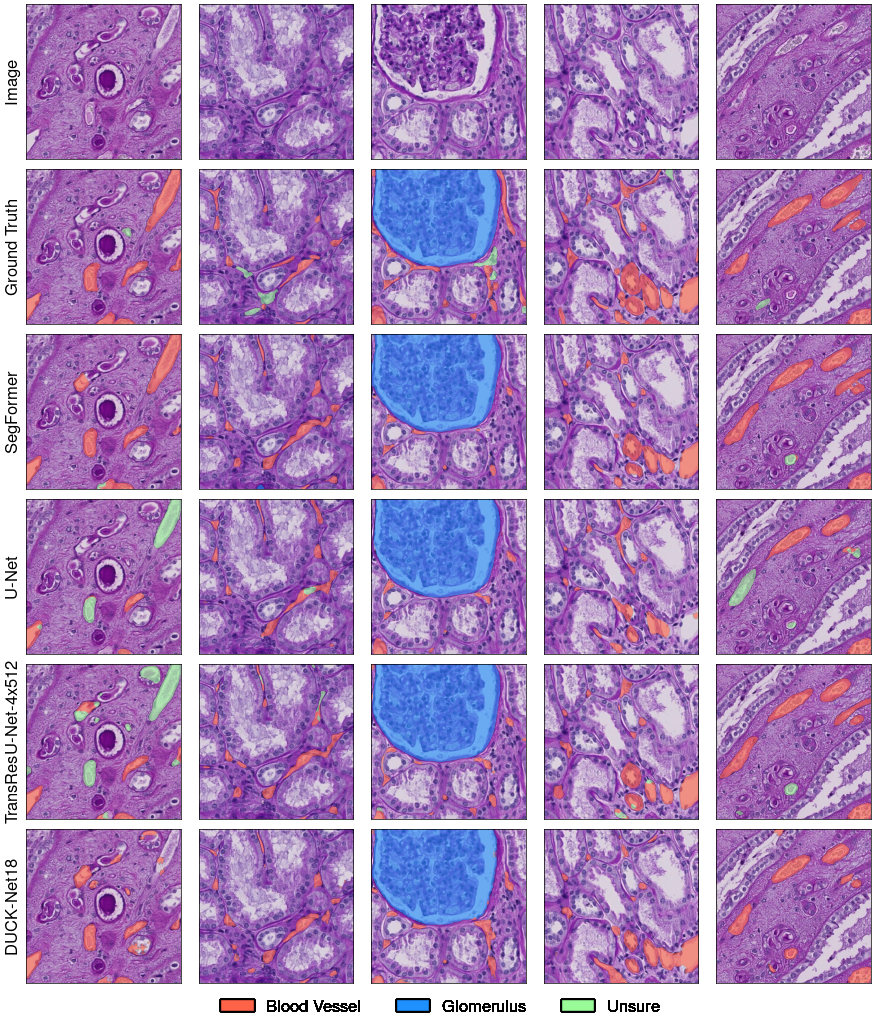

In [73]:
fig = visualize_detailed_results_overlay(base_images,targets, predictions_per_model)

In [74]:
fig.savefig("final_results.svg", format="svg")